In [1]:
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils;
from utils import *
import time
from __future__ import division, print_function
import sys
sys.path.insert(1, '/home/mh/opencv-master/build/lib/python3')
import cv2
import glob
from keras.optimizers import Adadelta

data_path = '/home/mh/ws/fish_challenge/input/'
model_path = '/home/mh/ws/fish_challenge/input/models/'
batch_size=32

batches = get_batches(data_path+'train', batch_size=batch_size)
val_batches = get_batches(data_path+'valid', batch_size=batch_size*2, shuffle=False)
test_filenames = get_batches(data_path+'test', batch_size=batch_size).filenames

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(data_path)

raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Load data.
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')
trn_labels = load_array(model_path+'trn_labels.bc')
val_labels = load_array(model_path+'val_labels.bc')
val_labels = onehot(val_labels)
trn_labels = onehot(trn_labels)

test_data = load_array(model_path+'test_data.bc')
test_data = test_data.transpose((0,3,1,2))

from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

model.load_weights(data_path+'results/ft1.h5')

conv_layers,fc_layers = split_at(model, Convolution2D)
conv_model = Sequential(conv_layers)
#load features
conv_feat = load_array(data_path+'results/conv_feat.dat')
conv_val_feat = load_array(data_path+'results/conv_val_feat.dat')
conv_test_feat = load_array(data_path+'results/conv_test_feat.dat')

model.summary()
for layer in model.layers:
    print(layer.name)


Using TensorFlow backend.


Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
___________________________________________

In [3]:
nf=128; p=0.
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ] 

fcn_model = Sequential(get_lrg_layers())
# fcn_model.summary()
fcn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# fcn_model.fit(conv_feat, trn_labels, batch_size=6, nb_epoch=3, validation_data=(conv_val_feat, val_labels))
fcn_model.load_weights(model_path+'/fcn_1.h5')

In [30]:
fcn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

fcn_model.evaluate(conv_val_feat, val_labels)

500/500 [==============================] - 5s      


[0.30357783174514769, 0.93799999904632569]

TypeError: Invalid dimensions for image data

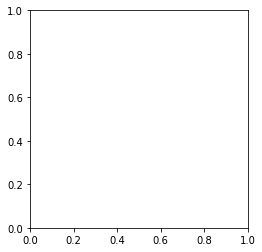

In [40]:
l = fcn_model.layers

conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])
def get_cm(imp, label):
    conv = conv_fn([imp,0])[0, label]
    return scipy.misc.imresize(conv, (224,224), interp='nearest')
inp = np.expand_dims(conv_val_feat[0], 2)
# print(inp)
# np.round(fcn_model.predict(inp)[0],2)
plt.imshow(to_plot(val_data[0]))
# cm = get_cm(inp, 0)
# plt.imshow(cm, cmap="cool")

In [39]:
MEAN_VALUES = np.array([103.939, 116.779, 123.68]).reshape((3,1,1))

# util function to convert a tensor into a valid image
def deprocess(x):
    x += MEAN_VALUES # Add VGG16 mean values
 
    x = x[::-1, :, :] # Change from BGR to RGB
    x = x.transpose((1, 2, 0)) # Change from (Channel,Height,Width) to (Height,Width,Channel)
    
    x = np.clip(x, 0, 255).astype('uint8') #clip in [0;255] and convert to int
    return x
 

input_img = fcn_model.layers[0].input
layer_output = fcn_model.layers[-4].output

kept_images = []
 
# Update coefficient
learning_rate = 500.
 
for class_index in [0, 1, 2, 3]: #130 flamingo, 351 hartebeest, 736 pool table, 850 teddy bear
    print('Processing filter %d' % class_index)
    start_time = time.time()
 
    # The loss is the activation of the neuron for the chosen class
    loss = layer_output[0, class_index]
 
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
 
    # this function returns the loss and grads given the input picture
    # also add a flag to disable the learning phase (in our case dropout)
    iterate = K.function([input_img, K.learning_phase()], [loss, grads])
 
    np.random.seed(1337)  # for reproducibility
    # we start from a gray image with some random noise
    input_img_data = np.random.normal(0, 10, (1,) + fcn_model.input_shape[1:]) # (1,) for batch axis
 
    # we run gradient ascent for 1000 steps
    for i in range(1000):
        loss_value, grads_value = iterate([input_img_data, 0]) # 0 for test phase
        input_img_data += grads_value * learning_rate # Apply gradient to image
 
        #print('Current loss value:', loss_value)
 
    # decode the resulting input image and add it to the list
    img = deprocess(input_img_data[0])
    kept_images.append((img, loss_value))
    end_time = time.time()
#     print('Filter %d processed in %ds' % (class_index, end_time - start_time))
#Compute the size of the grid
n = int(np.ceil(np.sqrt(len(kept_images))))
 
# build a black picture with enough space for the kept_images
img_height = model.input_shape[2]
img_width = model.input_shape[3]
margin = 5
height = n * img_height + (n - 1) * margin
width = n * img_width + (n - 1) * margin
stitched_res = np.zeros((height, width, 3))
 
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        if len(kept_images) <= i * n + j:
            break
        img, loss = kept_images[i * n + j]
        stitched_res[(img_height + margin) * i: (img_height + margin) * i + img_height,
                         (img_width + margin) * j: (img_width + margin) * j + img_width, :] = img

scipy.misc.toimage(stitched_res, cmin=0, cmax=255).save('naive_results_%dx%d.png' % (n, n)) # Do not use scipy.misc.imsave because it will normalize the image pixel value between 0 and 255
 

Processing filter 0


ValueError: operands could not be broadcast together with shapes (512,14,14) (3,1,1) (512,14,14) 

In [78]:
# conv_feat = conv_feat.transpose((0,2,1,3))
conv_feat.shape

(3277, 512, 14, 14)

In [87]:
# import cv2
# import numpy as np

# from keras.preprocessing.image import img_to_array
# from vis.utils import utils
# from vis.utils.vggnet import VGG16
# from vis.visualization import visualize_saliency


# # The name of the layer we want to visualize
# # (see model definition in vggnet.py)
# layer_name = 'convolution2d_13'
# layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

# # Images corresponding to tiger, penguin, dumbbell, speedboat, spider
# image_paths = [
#     data_path+'/train/LAG/img_00091.jpg'
# ]


# heatmaps = []
# for path in image_paths:
#     # Predict the corresponding class for use in `visualize_saliency`.
#     seed_img = utils.load_img(path, target_size=(14, 14))
#     pred_class = np.argmax(fcn_model.predict(np.array([img_to_array(conv_feat[2])])))

#     # Here we are asking it to show attention such that prob of `pred_class` is maximized.
#     heatmap = visualize_saliency(fcn_model, layer_idx, [pred_class], seed_img, )
#     heatmaps.append(heatmap)

# cv2.imshow("Saliency map", utils.stitch_images(heatmaps))
# cv2.waitKey(0)

# Build the VGG16 network with ImageNet weights
# model = VGG16(weights='imagenet', include_top=True)
# print('Model loaded.')

import cv2

from vis.utils.utils import stitch_images
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_activation

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'predictions'
# for idx, layer in enumerate(model.layers):
#     print(idx)
#     print(layer)
# layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

layer_idx = -4

# Generate three different images of the same output index.
vis_images = [visualize_activation(model, layer_idx, filter_indices=idx,  max_iter=500)
              for idx in [20, 20, 20]]
cv2.imshow(layer_name, stitch_images(vis_images))
cv2.waitKey(0)

TypeError: 'int' object is not iterable

In [5]:
import cv2
import numpy as np

from vis.utils.utils import stitch_images
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_activation, get_num_filters

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'convolution2d_13'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter. Here `text` field is used to overlay `filter_value` on top of the image.
vis_images = [visualize_activation(model, layer_idx, filter_indices=idx, text=str(idx))
              for idx in filters]

# Generate stitched image pallette with 10 cols.
cv2.imshow(layer_name, stitch_images(vis_images, cols=8))
cv2.waitKey(0)

ImportError: No module named 'losses'

In [54]:
from keras import backend as K
l = model.layers
print(l[-1].get_weights())
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])
def get_cm(imp, label):
    conv = conv_fn([imp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')
trn_data = trn_data.transpose((0,2,1,3))
print(trn_data[0].shape)
inp = np.expand_dims(trn_data[0], 0)
print(inp.shape)

# print(np.round(model.predict(inp)[0],2))
# plt.imshow(to_plot(val[0]))

cm = get_cm(inp, 0)
plt.imshow(cm, cmap="cool")

[array([[ 0.0465, -0.02  ,  0.0168, ..., -0.0228, -0.0025, -0.0278],
       [-0.0218,  0.0289,  0.0278, ..., -0.0155,  0.0191,  0.02  ],
       [-0.01  , -0.0256, -0.0342, ..., -0.0358, -0.0007,  0.0175],
       ..., 
       [ 0.0573, -0.0144, -0.0079, ...,  0.0832, -0.0315, -0.055 ],
       [ 0.0242, -0.0381,  0.0692, ...,  0.004 , -0.0363, -0.0567],
       [ 0.0114, -0.0155, -0.034 , ...,  0.0216,  0.0229, -0.041 ]], dtype=float32), array([ 0.0493, -0.0374, -0.0348, -0.0458, -0.0031, -0.0265, -0.043 ,  0.0383], dtype=float32)]
(224, 3, 224)
(1, 224, 3, 224)


ValueError: Cannot feed value of shape (1, 224, 3, 224) for Tensor 'lambda_input_1:0', which has shape '(?, 3, 224, 224)'

W shape :  []
W shape :  (0,)


IndexError: tuple index out of range

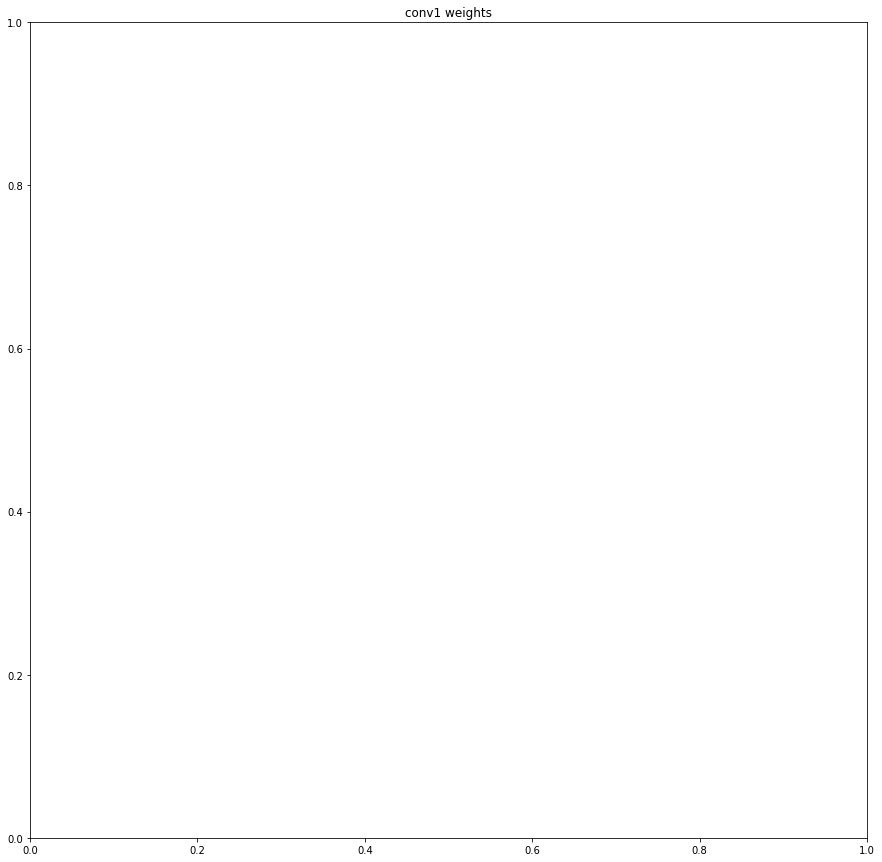

In [27]:
from keras import backend as K
import pylab as pl
import matplotlib.cm as cm
# l = model.layers
# Visualize weights
W = model.layers[1].get_weights()
print("W shape : ", W)
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

In [8]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

In [9]:

import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))